# **HW1-P2: Autoregressive Generative Models for Multivariate Time Series Generation**

In this assignment you will explore one of the state-of-the-art frameworks for generating high-fidelty time-series data. We will train four different autoregressive generative models and compare them with each other.

## Assignment Overview and Structure

### What You Will Do:
1. You'll create a synthesized time-series data of simple multi-dimensional sine waves with different characteristics.
2. You'll be asked to train these autoregressive models from scratch (using torch). In this part you might need to change and fine-tune hyperparameters several times to get a good result:
    - **RNN**
    - **LSTM**
    - **GRU** (you might not know this one. It's not that hard; it really resembles LSTM. Look it up in GPT or Google.)
    - **Transformer**

3. You'll train the models on the data and then generate a full sequence using them and compare them

---

# **Overlapping Windows Framework**

As you might know or not know, one fundumental problem with autoregressive models is that can accumulate over time indices and rise to very high values. One creative method of overcoming this issue is to teach the autoregressive generative model to generate small windows of data, conditioned on the position of the window. Then, for generating a full sequence, we can simply generate windows from all of the positions and stitch them together by averaging.

## Some Notes

* Using ChatGPT and other LLMs are allowed but you should be able to explain every line of your code completely.
* You need GPU for this assignment. You can use Colab or Kaggle for free.
* I highly recommend using the exact same structure and instructions that is provided for you in the notebook,a but minor changes will be tolerated.
* Read the whole notebook once before coding. It will give you a broad vision about what you should do on the whole.
* Your results should have the minimum quality of the results that already exists in the notebook.
* All of the parts that you should implement are marked with `#TODO`.

## Section 1: Setup and Imports

In [1]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


## Section 2: Create a Single Multivariate Sine-wave Series, Window, and Plot 

- Create a time series data consisting of $1$ sample with Length $T$, with $D$ dimensions; each dimension is a sine with its own amplitude ($\le 1$), frequency, and phase.
- No normalization/denormalization should be applied.
- Window the series with `window_size=15` and `stride=2`, returning overlapping windows.
- Plot the series and a few example windows.

Series shape: (5000, 3)
Amplitude per dim: [0.56217808 0.96550001 0.81239576]


Building windows:   0%|          | 0/2476 [00:00<?, ?it/s]

Windows shape: (2476, 50, 3)


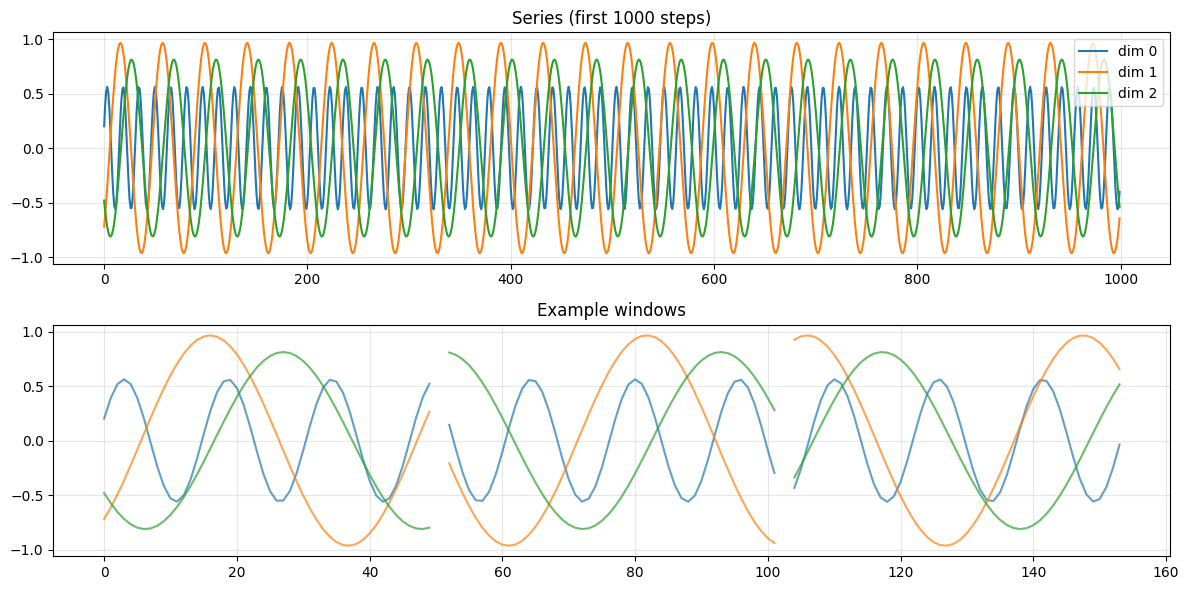

In [ ]:
# Configuration
T = 5000                # number of time steps
D = 3                   # number of dimensions
WINDOW_SIZE = 50
STRIDE = 2

## 1. Generate Multivariate Sine-wave Series
# Each dimension has its own amplitude (≤ 1), frequency and phase
t = np.arange(T)
series = np.zeros((T, D), dtype=np.float32)

amps = np.random.uniform(0.3, 1.0, size=D)      # amplitudes ≤ 1
freqs = np.random.uniform(0.01, 0.1, size=D)    # cycles per step
phases = np.random.uniform(0, 2*np.pi, size=D)

for d in range(D):
    series[:, d] = amps[d] * np.sin(2 * np.pi * freqs[d] * t + phases[d])

print("Series shape:", series.shape)
print("Amplitude per dim:", amps)


## 2. Window the Series
start_indices = np.arange(0, T - WINDOW_SIZE + 1, STRIDE)
windows = np.zeros((len(start_indices), WINDOW_SIZE, D), dtype=np.float32)

for i in tqdm(range(len(start_indices)), desc="Building windows", leave=False):
    start_idx = start_indices[i]
    end_idx = start_idx + WINDOW_SIZE
    windows[i] = series[start_idx:end_idx]

print("Windows shape:", windows.shape)


## 3. Plot Results
# Quick plots: full series (first 1000 steps) and a few sample windows
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=False)
steps_to_plot = 1000
axes[0].set_title("Series (first 1000 steps)")
for d in range(D):
    axes[0].plot(series[:steps_to_plot, d], label=f"dim {d}")
axes[0].legend(loc='upper right')
axes[0].grid(alpha=0.3)

axes[1].set_title("Example windows")
example_ids = [0, len(start_indices)//3, 2*len(start_indices)//3]
colors = ['C0','C1','C2','C3']
for idx_j, wi in enumerate(example_ids):
    w = windows[wi]
    for d in range(D):
        axes[1].plot(np.arange(WINDOW_SIZE) + idx_j*(WINDOW_SIZE+2), w[:, d], color=colors[d], alpha=0.7)
axes[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 4. Store Data
# Keep important objects in memory for later steps
DATA = {
    'series': series,
    'start_indices': start_indices,
    'windows': windows,
    'T': T,
     'D': D,
}

## Section 3: Dataset and Dataloaders

We construct a dataset from overlapping windows of the single series.
We split into train/val/test and build dataloaders.

In [ ]:
class WindowedSingleSeriesDataset(Dataset):
    def __init__(self, windows: np.ndarray, start_indices: np.ndarray):
        self.windows = windows  # shape: [N, W, D], normalized
        self.start_indices = start_indices.astype(np.int64)  # shape: [N]

    def __len__(self):
        return self.windows.shape[0]

    def __getitem__(self, idx):
        w = self.windows[idx]
        x = w[:-1]            # [W-1, D]
        y = w[1:]             # [W-1, D]
        s = self.start_indices[idx]  # scalar start index for conditioning
        return (
            torch.from_numpy(x).float(),
            torch.from_numpy(y).float(),
            torch.tensor(s, dtype=torch.long)
        )

# Train/val/test split along window index (maintaining time order)
N = DATA['windows'].shape[0]
idx_train = int(0.7 * N)
idx_val = int(0.85 * N)

train_ds = WindowedSingleSeriesDataset(DATA['windows'][:idx_train], DATA['start_indices'][:idx_train])
val_ds   = WindowedSingleSeriesDataset(DATA['windows'][idx_train:idx_val], DATA['start_indices'][idx_train:idx_val])
test_ds  = WindowedSingleSeriesDataset(DATA['windows'][idx_val:], DATA['start_indices'][idx_val:])

BATCH_SIZE = 64 
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print(len(train_ds), len(val_ds), len(test_ds))

1733 371 372


## Section 4: Implement RNN, LSTM, GRU, and Transformer Autoregressive Models 

- Conditioning: Each model receives the window start index (scalar) and maps it to a learned conditioning vector, concatenated/added to inputs at every time step.
- Training: Teacher forcing on windowed data (predict next step at each time), MSE loss.

In [4]:
# Helper Modules

class StartIndexEmbedding(nn.Module):
    def __init__(self, max_len: int, emb_dim: int):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings=max_len, embedding_dim=emb_dim)

    def forward(self, start_idx: torch.Tensor):
        return self.emb(start_idx)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 6000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # [1, max_len, d_model]

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [ ]:
# Utility Functions

def stitch_overlapping(windows: torch.Tensor, stride: int, total_len: int):
    """
    Windows: [N_win, W, D]
    Overlap-add by averaging overlapped positions.
    Returns [T, D].
    """
    N_win, W, D = windows.shape
    result = torch.zeros(total_len, D, dtype=windows.dtype, device=windows.device)
    counts = torch.zeros(total_len, dtype=windows.dtype, device=windows.device)

    for i in range(N_win):
        start_idx = i * stride
        end_idx = start_idx + W
        result[start_idx:end_idx] += windows[i]
        counts[start_idx:end_idx] += 1

    result = result / counts.unsqueeze(-1).clamp(min=1)
    return result

In [6]:
# Base Model
class BaseAR(nn.Module):
    def __init__(self, input_dim: int, cond_dim: int):
        super().__init__()
        self.input_dim = input_dim
        self.cond_dim = cond_dim

    @torch.no_grad()
    def generate_window(self, start_idx: int, steps: int, seed: torch.Tensor=None, device=None):
        raise NotImplementedError

    @torch.no_grad()
    def generate_full_sequence(self, stride: int, total_len: int, window_size: int,
                               seed_first: torch.Tensor=None, device=None):
        """Generate overlapped windows left-to-right, chaining seeds for continuity."""
        N_win = (total_len - window_size) // stride + 1
        all_windows = []
        dev = device or next(self.parameters()).device
        if seed_first is not None:
            seed_first = seed_first.to(dev)

        prev_w = None
        for i in range(N_win):
            start_idx = i * stride
            if i == 0:
                seed = seed_first  # [W-1, D] or None
            else:
                # reuse tail to warm the next window; length = W-1-STRIDE
                seed = prev_w[stride:stride + (window_size - 1)]
            w = self.generate_window(start_idx, window_size, seed=seed, device=dev)
            all_windows.append(w)
            prev_w = w

        all_windows = torch.stack(all_windows, dim=0)  # [N_win, W, D]
        stitched = stitch_overlapping(all_windows, stride, total_len)
        return stitched


# RNN Model
class RNNAR(BaseAR):
    def __init__(self, input_dim: int, hidden_dim: int, cond_dim: int, max_len: int, num_layers: int = 1):
        super().__init__(input_dim, cond_dim)
        self.sidx_emb = StartIndexEmbedding(max_len, cond_dim)
        self.rnn = nn.RNN(input_dim + cond_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.proj = nn.Linear(hidden_dim, input_dim)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

    def forward(self, x: torch.Tensor, sidx: torch.Tensor):
        cond = self.sidx_emb(sidx)                           # [B, C]
        cond_rep = cond.unsqueeze(1).repeat(1, x.size(1), 1) # [B, T, C]
        xr = torch.cat([x, cond_rep], dim=-1)                # [B, T, D+C]
        out_seq, _ = self.rnn(xr)                            # [B, T, H]
        y = self.proj(out_seq)                               # [B, T, D]
        return y

    @torch.no_grad()
    def generate_window(self, start_idx: int, steps: int, seed: torch.Tensor=None, device=None):
        dev = device or next(self.parameters()).device
        self.eval()

        if seed is None:
            seed = torch.zeros(0, self.input_dim, device=dev)  # allow any L≥0
        else:
            seed = seed.to(dev)

        L = seed.size(0)
        x = seed.unsqueeze(0)                                # [1, L, D]
        s = torch.tensor([start_idx], device=dev, dtype=torch.long)
        cond = self.sidx_emb(s)                              # [1, C]

        h_state = torch.zeros(self.num_layers, 1, self.hidden_dim, device=dev)
        out = []

        # consume seed
        for t in range(L):
            xt = x[:, t:t+1, :]
            xr = torch.cat([xt, cond.unsqueeze(1)], dim=-1)
            out_seq, h_state = self.rnn(xr, h_state)
            yt = self.proj(out_seq)
            out.append(yt.squeeze(1))

        # autoregress
        while len(out) < steps:
            last_in = out[-1].unsqueeze(1) if len(out) > 0 else torch.zeros(1, 1, self.input_dim, device=dev)
            xr = torch.cat([last_in, cond.unsqueeze(1)], dim=-1)
            out_seq, h_state = self.rnn(xr, h_state)
            yt = self.proj(out_seq)
            out.append(yt.squeeze(1))

        return torch.cat(out, dim=0)                         # [steps, D]


# LSTM Model
class LSTMAR(BaseAR):
    def __init__(self, input_dim: int, hidden_dim: int, cond_dim: int, max_len: int, num_layers: int = 1):
        super().__init__(input_dim, cond_dim)
        self.sidx_emb = StartIndexEmbedding(max_len, cond_dim)
        self.lstm = nn.LSTM(input_dim + cond_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.proj = nn.Linear(hidden_dim, input_dim)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

    def forward(self, x: torch.Tensor, sidx: torch.Tensor):
        cond = self.sidx_emb(sidx)
        cond_rep = cond.unsqueeze(1).repeat(1, x.size(1), 1)
        xr = torch.cat([x, cond_rep], dim=-1)
        out_seq, _ = self.lstm(xr)
        y = self.proj(out_seq)
        return y

    @torch.no_grad()
    def generate_window(self, start_idx: int, steps: int, seed: torch.Tensor=None, device=None):
        dev = device or next(self.parameters()).device
        self.eval()

        if seed is None:
            seed = torch.zeros(0, self.input_dim, device=dev)
        else:
            seed = seed.to(dev)

        L = seed.size(0)
        x = seed.unsqueeze(0)                                # [1, L, D]
        s = torch.tensor([start_idx], device=dev, dtype=torch.long)
        cond = self.sidx_emb(s)                              # [1, C]

        h_state = torch.zeros(self.num_layers, 1, self.hidden_dim, device=dev)
        c_state = torch.zeros(self.num_layers, 1, self.hidden_dim, device=dev)
        out = []

        # consume seed
        for t in range(L):
            xt = x[:, t:t+1, :]
            xr = torch.cat([xt, cond.unsqueeze(1)], dim=-1)
            out_seq, (h_state, c_state) = self.lstm(xr, (h_state, c_state))
            yt = self.proj(out_seq)
            out.append(yt.squeeze(1))

        # autoregress
        while len(out) < steps:
            last_in = out[-1].unsqueeze(1) if len(out) > 0 else torch.zeros(1, 1, self.input_dim, device=dev)
            xr = torch.cat([last_in, cond.unsqueeze(1)], dim=-1)
            out_seq, (h_state, c_state) = self.lstm(xr, (h_state, c_state))
            yt = self.proj(out_seq)
            out.append(yt.squeeze(1))

        return torch.cat(out, dim=0)                         # [steps, D]


# GRU Model
class GRUAR(BaseAR):
    def __init__(self, input_dim: int, hidden_dim: int, cond_dim: int, max_len: int, num_layers: int = 1):
        super().__init__(input_dim, cond_dim)
        self.sidx_emb = StartIndexEmbedding(max_len, cond_dim)
        self.gru = nn.GRU(input_dim + cond_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.proj = nn.Linear(hidden_dim, input_dim)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

    def forward(self, x: torch.Tensor, sidx: torch.Tensor):
        cond = self.sidx_emb(sidx)
        cond_rep = cond.unsqueeze(1).repeat(1, x.size(1), 1)
        xr = torch.cat([x, cond_rep], dim=-1)
        out_seq, _ = self.gru(xr)
        y = self.proj(out_seq)
        return y

    @torch.no_grad()
    def generate_window(self, start_idx: int, steps: int, seed: torch.Tensor=None, device=None):
        dev = device or next(self.parameters()).device
        self.eval()

        if seed is None:
            seed = torch.zeros(0, self.input_dim, device=dev)
        else:
            seed = seed.to(dev)

        L = seed.size(0)
        x = seed.unsqueeze(0)                                # [1, L, D]
        s = torch.tensor([start_idx], device=dev, dtype=torch.long)
        cond = self.sidx_emb(s)                              # [1, C]

        h_state = torch.zeros(self.num_layers, 1, self.hidden_dim, device=dev)
        out = []

        # consume seed
        for t in range(L):
            xt = x[:, t:t+1, :]
            xr = torch.cat([xt, cond.unsqueeze(1)], dim=-1)
            out_seq, h_state = self.gru(xr, h_state)
            yt = self.proj(out_seq)
            out.append(yt.squeeze(1))

        # autoregress
        while len(out) < steps:
            last_in = out[-1].unsqueeze(1) if len(out) > 0 else torch.zeros(1, 1, self.input_dim, device=dev)
            xr = torch.cat([last_in, cond.unsqueeze(1)], dim=-1)
            out_seq, h_state = self.gru(xr, h_state)
            yt = self.proj(out_seq)
            out.append(yt.squeeze(1))

        return torch.cat(out, dim=0)                         # [steps, D]


# Transformer Model
class TransformerAR(BaseAR):
    def __init__(self, input_dim: int, d_model: int, nhead: int, num_layers: int, cond_dim: int, max_len: int, dim_feedforward: int=128):
        super().__init__(input_dim, cond_dim)
        self.sidx_emb = StartIndexEmbedding(max_len, cond_dim)
        self.inp = nn.Linear(input_dim + cond_dim, d_model)
        self.pos = PositionalEncoding(d_model, max_len=2048)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True, activation='gelu')
        self.enc = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.proj = nn.Linear(d_model, input_dim)

    def forward(self, x: torch.Tensor, sidx: torch.Tensor):
        B, T, _ = x.shape
        cond = self.sidx_emb(sidx)
        cond_rep = cond.unsqueeze(1).repeat(1, T, 1)
        xr = torch.cat([x, cond_rep], dim=-1)
        h = self.inp(xr)
        h = self.pos(h)

        # causal mask for auto-regressive training
        Tt = h.size(1)
        mask = nn.Transformer.generate_square_subsequent_mask(Tt, device=h.device)
        h = self.enc(h, mask=mask, is_causal=False)
        y = self.proj(h)
        return y

    @torch.no_grad()
    def generate_window(self, start_idx: int, steps: int, seed: torch.Tensor=None, device=None):
        dev = device or next(self.parameters()).device
        self.eval()

        s = torch.tensor([start_idx], device=dev, dtype=torch.long)
        cond = self.sidx_emb(s)  # [1, C]

        if seed is None:
            x_seq = torch.zeros(1, self.input_dim, device=dev)
        else:
            x_seq = seed.clone().to(dev)
            if x_seq.size(0) >= steps:
                return x_seq[:steps]

        # roll one step at a time autoregressively
        while x_seq.size(0) < steps:
            T = x_seq.size(0)

            cond_rep = cond.unsqueeze(1).repeat(1, T, 1).squeeze(0)

            xr = torch.cat([x_seq, cond_rep], dim=-1)

            h = self.inp(xr)
            h_batch = h.unsqueeze(0)
            h_batch = self.pos(h_batch)

            mask = nn.Transformer.generate_square_subsequent_mask(T, device=dev)

            h_out_batch = self.enc(h_batch, mask=mask, is_causal=False)
            h_out = h_out_batch.squeeze(0)
            y_last = self.proj(h_out[-1:])
            if seed is None and x_seq.size(0) == 1 and torch.all(x_seq == 0):
                x_seq = y_last
            else:
                x_seq = torch.cat([x_seq, y_last], dim=0)

        # take exactly steps outputs
        return x_seq[:steps]                                 # [steps, D]


## Section 5: Instantiate Models with Roughly Equal Parameter Counts

We choose hidden sizes so total parameters per model are similar.
In this part you should fine-tune all of the hyperparameters to achieve a good result.

In [ ]:
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


MAX_LEN = DATA['T']  # for start-index embedding
COND_DIM = 32

# Roughly match parameter counts by tuning hidden sizes and layers
RNN_H = 450; RNN_L = 8
LSTM_H = 222; LSTM_L = 8
GRU_H = 170; GRU_L = 18
T_D_MODEL = 256; T_NHEAD = 8; T_LAYERS = 8; T_FF = 256
# T_D_MODEL = 200; T_NHEAD = 4; T_LAYERS = 8; T_FF = 512

rnn_model = RNNAR(input_dim=D, hidden_dim=RNN_H, cond_dim=COND_DIM, max_len=MAX_LEN, num_layers=RNN_L).to(device)
lstm_model = LSTMAR(input_dim=D, hidden_dim=LSTM_H, cond_dim=COND_DIM, max_len=MAX_LEN, num_layers=LSTM_L).to(device)
gru_model = GRUAR(input_dim=D, hidden_dim=GRU_H, cond_dim=COND_DIM, max_len=MAX_LEN, num_layers=GRU_L).to(device)
tr_model = TransformerAR(input_dim=D, d_model=T_D_MODEL, nhead=T_NHEAD, num_layers=T_LAYERS, cond_dim=COND_DIM, max_len=MAX_LEN, dim_feedforward=T_FF).to(device)

for name, m in [("RNN", rnn_model), ("LSTM", lstm_model), ("GRU", gru_model), ("Transformer", tr_model)]:
    print(f"{name} params: {count_parameters(m):,}")

RNN params: 3,221,803
LSTM params: 3,162,997
GRU params: 3,231,223
Transformer params: 3,336,195


## Section 6: Training Loops 

We train using MSE loss to predict next-step over each window.

In [8]:
def train_one_model(model: nn.Module, train_loader, val_loader, epochs=8, lr=1e-3):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_losses = []
    val_losses = []

    # TODO
    for ep in range(epochs):
        # train
        model.train()
        running = 0.0
        pbar = tqdm(train_loader, desc=f"Train {model.__class__.__name__} ep {ep+1}/{epochs}")

        for x, y, s in pbar:
            x, y, s = x.to(device), y.to(device), s.to(device)
            opt.zero_grad()
            y_pred = model(x, s)
            loss = criterion(y_pred, y)
            loss.backward()
            opt.step()
            running += loss.item() * x.size(0)
            pbar.set_postfix({'loss': loss.item()})

        train_loss = running / len(train_loader.dataset)
        train_losses.append(train_loss)

        # validation
        model.eval()
        val_running = 0.0

        with torch.no_grad():
            for x, y, s in tqdm(val_loader, desc=f"Val {model.__class__.__name__} ep {ep+1}/{epochs}", leave=False):
                x, y, s = x.to(device), y.to(device), s.to(device)
                y_pred = model(x, s)
                loss = criterion(y_pred, y)
                val_running += loss.item() * x.size(0)

        val_loss = val_running / len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f"Epoch {ep+1}: train {train_loss:.5f} | val {val_loss:.5f}")

    return train_losses, val_losses

EPOCHS = 50
LR = 1e-4
all_hist = {}
final_val_losses = {}

for name, m in [("RNN", rnn_model), ("LSTM", lstm_model), ("GRU", gru_model), ("Transformer", tr_model)]:
    print(f"\n===> Training {name}")
    tr, vl = train_one_model(m, train_loader, val_loader, epochs=EPOCHS, lr=LR)
    all_hist[name] = {'train': tr, 'val': vl}
    final_val_losses[name] = vl[-1]
    print(f"Final validation loss for {name}: {vl[-1]:.5f}")

print("\nFinal validation losses:")
for k, v in final_val_losses.items():
    print(f"{k}: {v:.5f}")


===> Training RNN


Train RNNAR ep 1/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 1/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1: train 0.13748 | val 0.07138


Train RNNAR ep 2/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 2/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2: train 0.03982 | val 0.02291


Train RNNAR ep 3/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 3/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3: train 0.01834 | val 0.01519


Train RNNAR ep 4/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 4/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4: train 0.01319 | val 0.01157


Train RNNAR ep 5/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 5/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5: train 0.01012 | val 0.00891


Train RNNAR ep 6/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 6/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6: train 0.00773 | val 0.00678


Train RNNAR ep 7/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 7/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7: train 0.00587 | val 0.00515


Train RNNAR ep 8/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 8/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8: train 0.00443 | val 0.00381


Train RNNAR ep 9/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 9/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9: train 0.00326 | val 0.00281


Train RNNAR ep 10/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 10/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10: train 0.00240 | val 0.00210


Train RNNAR ep 11/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 11/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11: train 0.00181 | val 0.00158


Train RNNAR ep 12/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 12/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12: train 0.00142 | val 0.00128


Train RNNAR ep 13/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 13/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13: train 0.00113 | val 0.00104


Train RNNAR ep 14/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 14/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14: train 0.00093 | val 0.00082


Train RNNAR ep 15/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 15/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15: train 0.00079 | val 0.00080


Train RNNAR ep 16/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 16/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16: train 0.00084 | val 0.00086


Train RNNAR ep 17/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 17/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17: train 0.00076 | val 0.00080


Train RNNAR ep 18/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 18/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18: train 0.00074 | val 0.00074


Train RNNAR ep 19/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 19/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19: train 0.00073 | val 0.00078


Train RNNAR ep 20/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 20/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20: train 0.00078 | val 0.00078


Train RNNAR ep 21/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 21/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 21: train 0.00079 | val 0.00071


Train RNNAR ep 22/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 22/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 22: train 0.00073 | val 0.00079


Train RNNAR ep 23/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 23/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 23: train 0.00070 | val 0.00072


Train RNNAR ep 24/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 24/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 24: train 0.00073 | val 0.00081


Train RNNAR ep 25/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 25/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 25: train 0.00075 | val 0.00080


Train RNNAR ep 26/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 26/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 26: train 0.00073 | val 0.00064


Train RNNAR ep 27/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 27/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 27: train 0.00068 | val 0.00067


Train RNNAR ep 28/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 28/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 28: train 0.00073 | val 0.00078


Train RNNAR ep 29/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 29/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 29: train 0.00072 | val 0.00073


Train RNNAR ep 30/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 30/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 30: train 0.00067 | val 0.00071


Train RNNAR ep 31/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 31/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 31: train 0.00069 | val 0.00070


Train RNNAR ep 32/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 32/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 32: train 0.00068 | val 0.00076


Train RNNAR ep 33/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 33/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 33: train 0.00068 | val 0.00065


Train RNNAR ep 34/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 34/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 34: train 0.00066 | val 0.00069


Train RNNAR ep 35/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 35/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 35: train 0.00066 | val 0.00072


Train RNNAR ep 36/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 36/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 36: train 0.00069 | val 0.00068


Train RNNAR ep 37/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 37/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 37: train 0.00064 | val 0.00066


Train RNNAR ep 38/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 38/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 38: train 0.00061 | val 0.00065


Train RNNAR ep 39/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 39/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 39: train 0.00062 | val 0.00063


Train RNNAR ep 40/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 40/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 40: train 0.00060 | val 0.00065


Train RNNAR ep 41/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 41/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 41: train 0.00063 | val 0.00063


Train RNNAR ep 42/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 42/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 42: train 0.00062 | val 0.00066


Train RNNAR ep 43/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 43/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 43: train 0.00065 | val 0.00069


Train RNNAR ep 44/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 44/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 44: train 0.00064 | val 0.00063


Train RNNAR ep 45/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 45/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 45: train 0.00066 | val 0.00075


Train RNNAR ep 46/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 46/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 46: train 0.00065 | val 0.00067


Train RNNAR ep 47/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 47/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 47: train 0.00066 | val 0.00062


Train RNNAR ep 48/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 48/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 48: train 0.00064 | val 0.00063


Train RNNAR ep 49/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 49/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 49: train 0.00061 | val 0.00063


Train RNNAR ep 50/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val RNNAR ep 50/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 50: train 0.00060 | val 0.00062
Final validation loss for RNN: 0.00062

===> Training LSTM


Train LSTMAR ep 1/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 1/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1: train 0.31778 | val 0.31802


Train LSTMAR ep 2/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 2/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2: train 0.31481 | val 0.29746


Train LSTMAR ep 3/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 3/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3: train 0.21031 | val 0.14028


Train LSTMAR ep 4/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 4/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4: train 0.12384 | val 0.11007


Train LSTMAR ep 5/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 5/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5: train 0.10223 | val 0.09602


Train LSTMAR ep 6/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 6/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6: train 0.09102 | val 0.08711


Train LSTMAR ep 7/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 7/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7: train 0.08379 | val 0.08136


Train LSTMAR ep 8/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 8/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8: train 0.07899 | val 0.07732


Train LSTMAR ep 9/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 9/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9: train 0.07543 | val 0.07426


Train LSTMAR ep 10/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 10/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10: train 0.07270 | val 0.07188


Train LSTMAR ep 11/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 11/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11: train 0.07057 | val 0.06996


Train LSTMAR ep 12/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 12/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12: train 0.06882 | val 0.06838


Train LSTMAR ep 13/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 13/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13: train 0.06737 | val 0.06704


Train LSTMAR ep 14/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 14/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14: train 0.06615 | val 0.06592


Train LSTMAR ep 15/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 15/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15: train 0.06507 | val 0.06491


Train LSTMAR ep 16/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 16/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16: train 0.06413 | val 0.06398


Train LSTMAR ep 17/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 17/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17: train 0.06328 | val 0.06319


Train LSTMAR ep 18/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 18/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18: train 0.06253 | val 0.06247


Train LSTMAR ep 19/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 19/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19: train 0.06187 | val 0.06181


Train LSTMAR ep 20/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 20/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20: train 0.06121 | val 0.06119


Train LSTMAR ep 21/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 21/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 21: train 0.06058 | val 0.06059


Train LSTMAR ep 22/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 22/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 22: train 0.06003 | val 0.06002


Train LSTMAR ep 23/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 23/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 23: train 0.05952 | val 0.05953


Train LSTMAR ep 24/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 24/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 24: train 0.05901 | val 0.05912


Train LSTMAR ep 25/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 25/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 25: train 0.05860 | val 0.05870


Train LSTMAR ep 26/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 26/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 26: train 0.05821 | val 0.05830


Train LSTMAR ep 27/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 27/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 27: train 0.05785 | val 0.05798


Train LSTMAR ep 28/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 28/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 28: train 0.05757 | val 0.05772


Train LSTMAR ep 29/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 29/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 29: train 0.05726 | val 0.05742


Train LSTMAR ep 30/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 30/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 30: train 0.05703 | val 0.05716


Train LSTMAR ep 31/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 31/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 31: train 0.05675 | val 0.05693


Train LSTMAR ep 32/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 32/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 32: train 0.05650 | val 0.05665


Train LSTMAR ep 33/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 33/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 33: train 0.05625 | val 0.05640


Train LSTMAR ep 34/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 34/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 34: train 0.05597 | val 0.05610


Train LSTMAR ep 35/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 35/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 35: train 0.05569 | val 0.05583


Train LSTMAR ep 36/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 36/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 36: train 0.05541 | val 0.05551


Train LSTMAR ep 37/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 37/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 37: train 0.05507 | val 0.05519


Train LSTMAR ep 38/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 38/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 38: train 0.05477 | val 0.05486


Train LSTMAR ep 39/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 39/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 39: train 0.05442 | val 0.05453


Train LSTMAR ep 40/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 40/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 40: train 0.05411 | val 0.05425


Train LSTMAR ep 41/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 41/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 41: train 0.05385 | val 0.05400


Train LSTMAR ep 42/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 42/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 42: train 0.05363 | val 0.05379


Train LSTMAR ep 43/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 43/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 43: train 0.05343 | val 0.05360


Train LSTMAR ep 44/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 44/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 44: train 0.05327 | val 0.05348


Train LSTMAR ep 45/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 45/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 45: train 0.05313 | val 0.05335


Train LSTMAR ep 46/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 46/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 46: train 0.05304 | val 0.05327


Train LSTMAR ep 47/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 47/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 47: train 0.05297 | val 0.05320


Train LSTMAR ep 48/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 48/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 48: train 0.05292 | val 0.05314


Train LSTMAR ep 49/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 49/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 49: train 0.05287 | val 0.05312


Train LSTMAR ep 50/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val LSTMAR ep 50/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 50: train 0.05283 | val 0.05308
Final validation loss for LSTM: 0.05308

===> Training GRU


Train GRUAR ep 1/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 1/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1: train 0.31762 | val 0.31790


Train GRUAR ep 2/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 2/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2: train 0.27411 | val 0.17351


Train GRUAR ep 3/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 3/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3: train 0.15119 | val 0.13046


Train GRUAR ep 4/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 4/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4: train 0.11901 | val 0.10943


Train GRUAR ep 5/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 5/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5: train 0.10080 | val 0.09384


Train GRUAR ep 6/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 6/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6: train 0.08858 | val 0.08436


Train GRUAR ep 7/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 7/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7: train 0.08101 | val 0.07843


Train GRUAR ep 8/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 8/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8: train 0.07597 | val 0.07427


Train GRUAR ep 9/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 9/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9: train 0.07238 | val 0.07108


Train GRUAR ep 10/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 10/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10: train 0.06951 | val 0.06861


Train GRUAR ep 11/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 11/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11: train 0.06728 | val 0.06657


Train GRUAR ep 12/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 12/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12: train 0.06544 | val 0.06492


Train GRUAR ep 13/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 13/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13: train 0.06390 | val 0.06344


Train GRUAR ep 14/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 14/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14: train 0.06247 | val 0.06213


Train GRUAR ep 15/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 15/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15: train 0.06131 | val 0.06102


Train GRUAR ep 16/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 16/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16: train 0.06027 | val 0.06011


Train GRUAR ep 17/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 17/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17: train 0.05950 | val 0.05940


Train GRUAR ep 18/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 18/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18: train 0.05877 | val 0.05865


Train GRUAR ep 19/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 19/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19: train 0.05810 | val 0.05800


Train GRUAR ep 20/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 20/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20: train 0.05745 | val 0.05736


Train GRUAR ep 21/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 21/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 21: train 0.05672 | val 0.05663


Train GRUAR ep 22/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 22/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 22: train 0.05596 | val 0.05580


Train GRUAR ep 23/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 23/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 23: train 0.05525 | val 0.05511


Train GRUAR ep 24/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 24/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 24: train 0.05462 | val 0.05464


Train GRUAR ep 25/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 25/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 25: train 0.05412 | val 0.05428


Train GRUAR ep 26/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 26/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 26: train 0.05378 | val 0.05388


Train GRUAR ep 27/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 27/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 27: train 0.05351 | val 0.05351


Train GRUAR ep 28/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 28/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 28: train 0.05310 | val 0.05312


Train GRUAR ep 29/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 29/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 29: train 0.05260 | val 0.05253


Train GRUAR ep 30/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 30/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 30: train 0.05150 | val 0.05096


Train GRUAR ep 31/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 31/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 31: train 0.04844 | val 0.04571


Train GRUAR ep 32/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 32/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 32: train 0.04132 | val 0.03736


Train GRUAR ep 33/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 33/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 33: train 0.03252 | val 0.02878


Train GRUAR ep 34/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 34/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 34: train 0.02405 | val 0.02106


Train GRUAR ep 35/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 35/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 35: train 0.01898 | val 0.01742


Train GRUAR ep 36/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 36/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 36: train 0.01563 | val 0.01526


Train GRUAR ep 37/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 37/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 37: train 0.01384 | val 0.01421


Train GRUAR ep 38/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 38/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 38: train 0.01303 | val 0.01311


Train GRUAR ep 39/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 39/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 39: train 0.01222 | val 0.01232


Train GRUAR ep 40/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 40/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 40: train 0.01174 | val 0.01212


Train GRUAR ep 41/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 41/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 41: train 0.01137 | val 0.01152


Train GRUAR ep 42/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 42/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 42: train 0.01107 | val 0.01166


Train GRUAR ep 43/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 43/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 43: train 0.01088 | val 0.01110


Train GRUAR ep 44/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 44/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 44: train 0.01060 | val 0.01111


Train GRUAR ep 45/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 45/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 45: train 0.01026 | val 0.01054


Train GRUAR ep 46/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 46/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 46: train 0.01005 | val 0.01112


Train GRUAR ep 47/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 47/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 47: train 0.01006 | val 0.01051


Train GRUAR ep 48/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 48/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 48: train 0.00981 | val 0.01027


Train GRUAR ep 49/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 49/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 49: train 0.00970 | val 0.01036


Train GRUAR ep 50/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val GRUAR ep 50/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 50: train 0.00948 | val 0.00988
Final validation loss for GRU: 0.00988

===> Training Transformer


Train TransformerAR ep 1/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 1/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1: train 0.35496 | val 0.29539


Train TransformerAR ep 2/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 2/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2: train 0.26566 | val 0.16665


Train TransformerAR ep 3/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 3/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3: train 0.12235 | val 0.06747


Train TransformerAR ep 4/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 4/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4: train 0.07200 | val 0.04100


Train TransformerAR ep 5/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 5/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5: train 0.05031 | val 0.02109


Train TransformerAR ep 6/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 6/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6: train 0.03583 | val 0.01212


Train TransformerAR ep 7/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 7/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7: train 0.02850 | val 0.00897


Train TransformerAR ep 8/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 8/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8: train 0.02404 | val 0.00680


Train TransformerAR ep 9/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 9/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9: train 0.02069 | val 0.00573


Train TransformerAR ep 10/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 10/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10: train 0.01830 | val 0.00441


Train TransformerAR ep 11/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 11/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11: train 0.01623 | val 0.00395


Train TransformerAR ep 12/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 12/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12: train 0.01489 | val 0.00335


Train TransformerAR ep 13/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 13/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13: train 0.01363 | val 0.00302


Train TransformerAR ep 14/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 14/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14: train 0.01262 | val 0.00300


Train TransformerAR ep 15/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 15/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15: train 0.01182 | val 0.00266


Train TransformerAR ep 16/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 16/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16: train 0.01099 | val 0.00232


Train TransformerAR ep 17/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 17/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17: train 0.01044 | val 0.00213


Train TransformerAR ep 18/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 18/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18: train 0.00981 | val 0.00202


Train TransformerAR ep 19/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 19/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19: train 0.00935 | val 0.00198


Train TransformerAR ep 20/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 20/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20: train 0.00885 | val 0.00181


Train TransformerAR ep 21/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 21/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 21: train 0.00847 | val 0.00185


Train TransformerAR ep 22/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 22/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 22: train 0.00811 | val 0.00183


Train TransformerAR ep 23/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 23/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 23: train 0.00783 | val 0.00167


Train TransformerAR ep 24/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 24/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 24: train 0.00747 | val 0.00157


Train TransformerAR ep 25/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 25/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 25: train 0.00718 | val 0.00156


Train TransformerAR ep 26/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 26/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 26: train 0.00694 | val 0.00150


Train TransformerAR ep 27/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 27/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 27: train 0.00669 | val 0.00155


Train TransformerAR ep 28/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 28/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 28: train 0.00654 | val 0.00143


Train TransformerAR ep 29/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 29/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 29: train 0.00621 | val 0.00139


Train TransformerAR ep 30/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 30/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 30: train 0.00612 | val 0.00136


Train TransformerAR ep 31/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 31/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 31: train 0.00585 | val 0.00123


Train TransformerAR ep 32/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 32/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 32: train 0.00575 | val 0.00130


Train TransformerAR ep 33/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 33/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 33: train 0.00553 | val 0.00125


Train TransformerAR ep 34/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 34/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 34: train 0.00536 | val 0.00122


Train TransformerAR ep 35/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 35/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 35: train 0.00530 | val 0.00117


Train TransformerAR ep 36/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 36/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 36: train 0.00509 | val 0.00116


Train TransformerAR ep 37/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 37/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 37: train 0.00504 | val 0.00112


Train TransformerAR ep 38/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 38/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 38: train 0.00489 | val 0.00129


Train TransformerAR ep 39/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 39/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 39: train 0.00474 | val 0.00102


Train TransformerAR ep 40/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 40/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 40: train 0.00463 | val 0.00107


Train TransformerAR ep 41/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 41/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 41: train 0.00454 | val 0.00117


Train TransformerAR ep 42/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 42/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 42: train 0.00439 | val 0.00108


Train TransformerAR ep 43/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 43/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 43: train 0.00432 | val 0.00114


Train TransformerAR ep 44/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 44/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 44: train 0.00426 | val 0.00104


Train TransformerAR ep 45/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 45/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 45: train 0.00416 | val 0.00095


Train TransformerAR ep 46/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 46/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 46: train 0.00405 | val 0.00093


Train TransformerAR ep 47/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 47/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 47: train 0.00395 | val 0.00100


Train TransformerAR ep 48/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 48/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 48: train 0.00389 | val 0.00092


Train TransformerAR ep 49/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 49/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 49: train 0.00385 | val 0.00102


Train TransformerAR ep 50/50:   0%|          | 0/27 [00:00<?, ?it/s]

Val TransformerAR ep 50/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 50: train 0.00374 | val 0.00091
Final validation loss for Transformer: 0.00091

Final validation losses:
RNN: 0.00062
LSTM: 0.05308
GRU: 0.00988
Transformer: 0.00091


## Section 7: Plot Training Curves

We plot per-epoch training and validation loss for all four models.

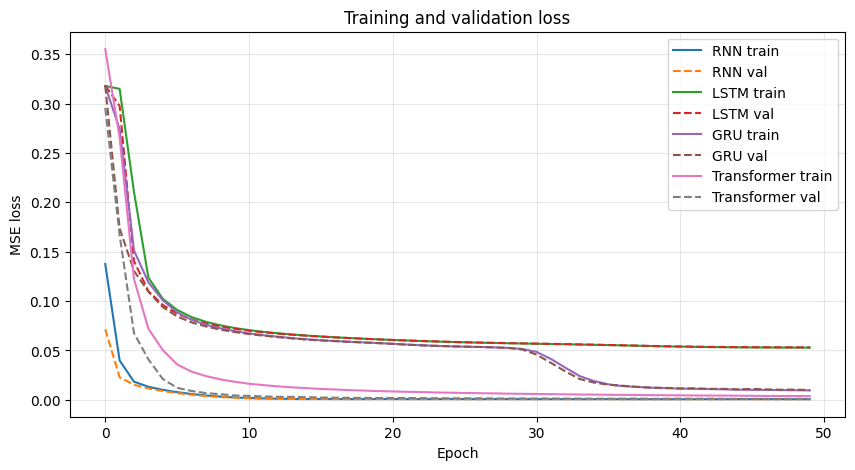

In [9]:
plt.figure(figsize=(10,5))

for name in all_hist:
    plt.plot(all_hist[name]['train'], label=f"{name} train")
    plt.plot(all_hist[name]['val'], '--', label=f"{name} val")

plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title('Training and validation loss')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

## Section 8: Generate Full Sequences and Plot Against Ground Truth 

We generate using overlapped windows stitched by averaging for each model. For visualization, we:
- Show each model separately.
- Within each model, show each dimension on its own subplot.
- Indicate train/val/test regions on the time axis.

Most of this section's points are awarded for the quality of the outputs! Try to get a good result!
Don't forget that these are generative models! The whole point of them is to "resemble" but not be "identical" to their training data!

RNN mean var across dims: 0.082712
LSTM mean var across dims: 0.070116
GRU mean var across dims: 0.053224
Transformer mean var across dims: 0.333068


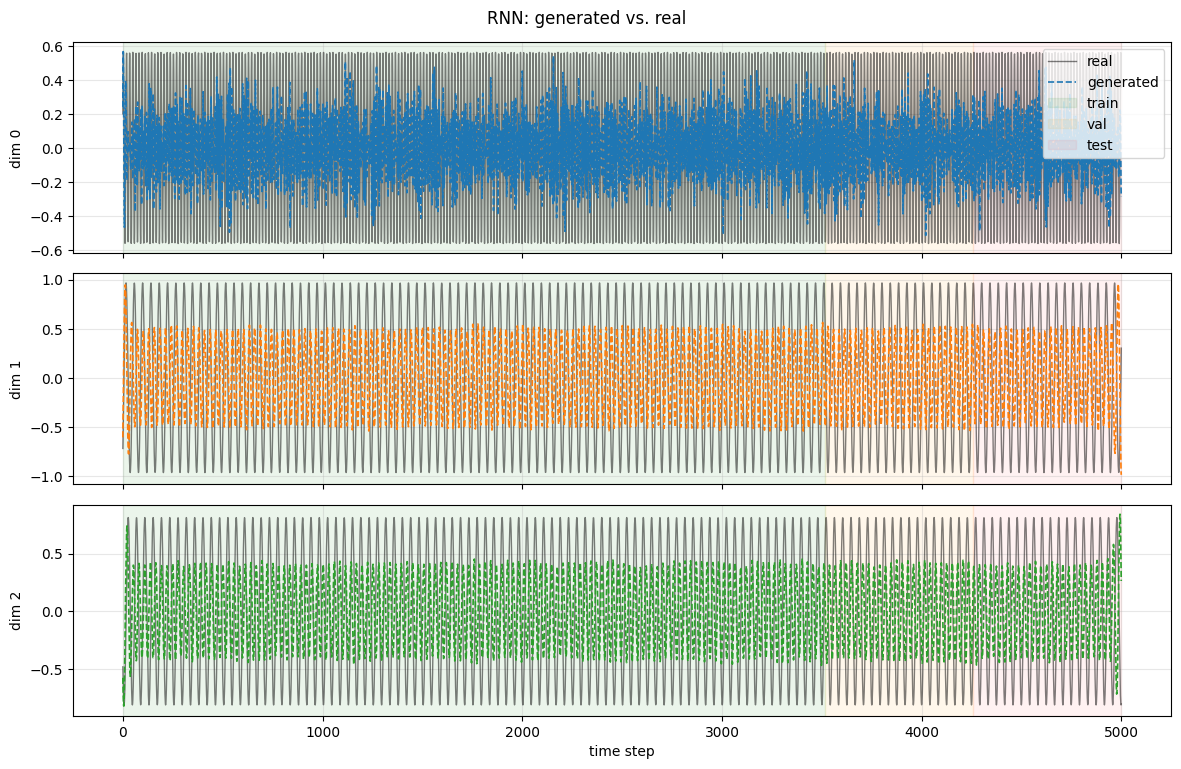

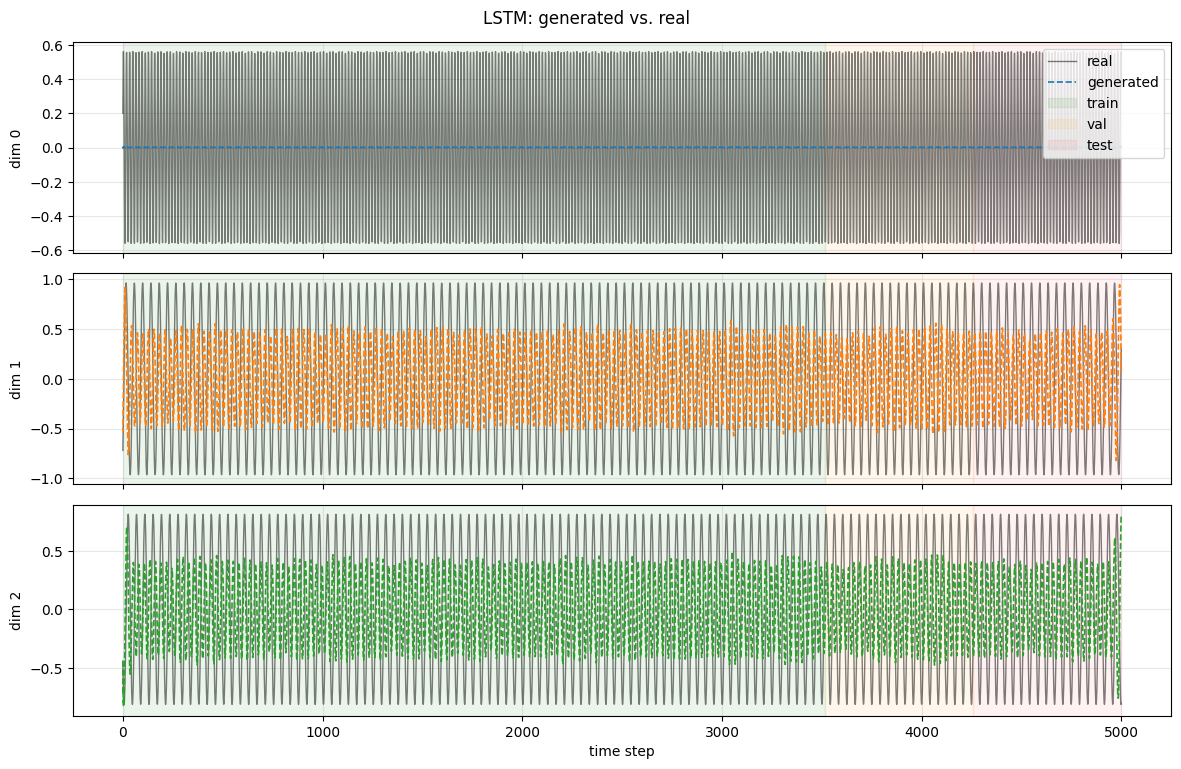

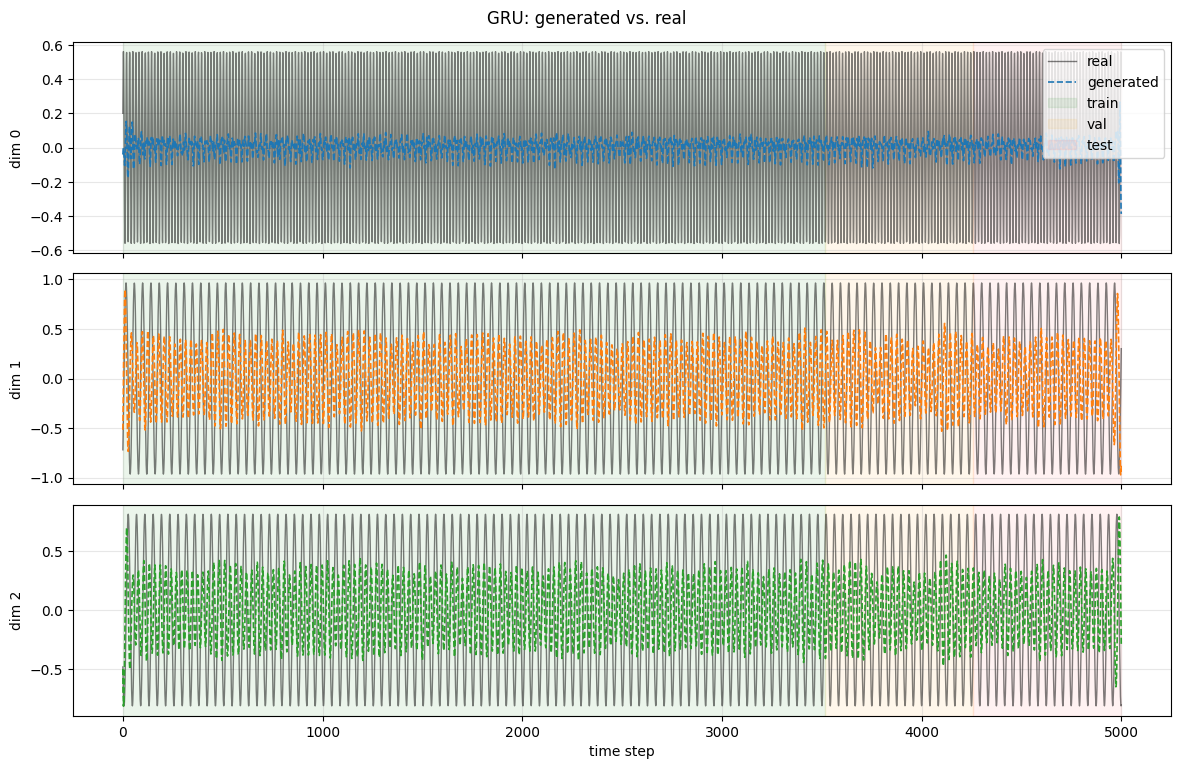

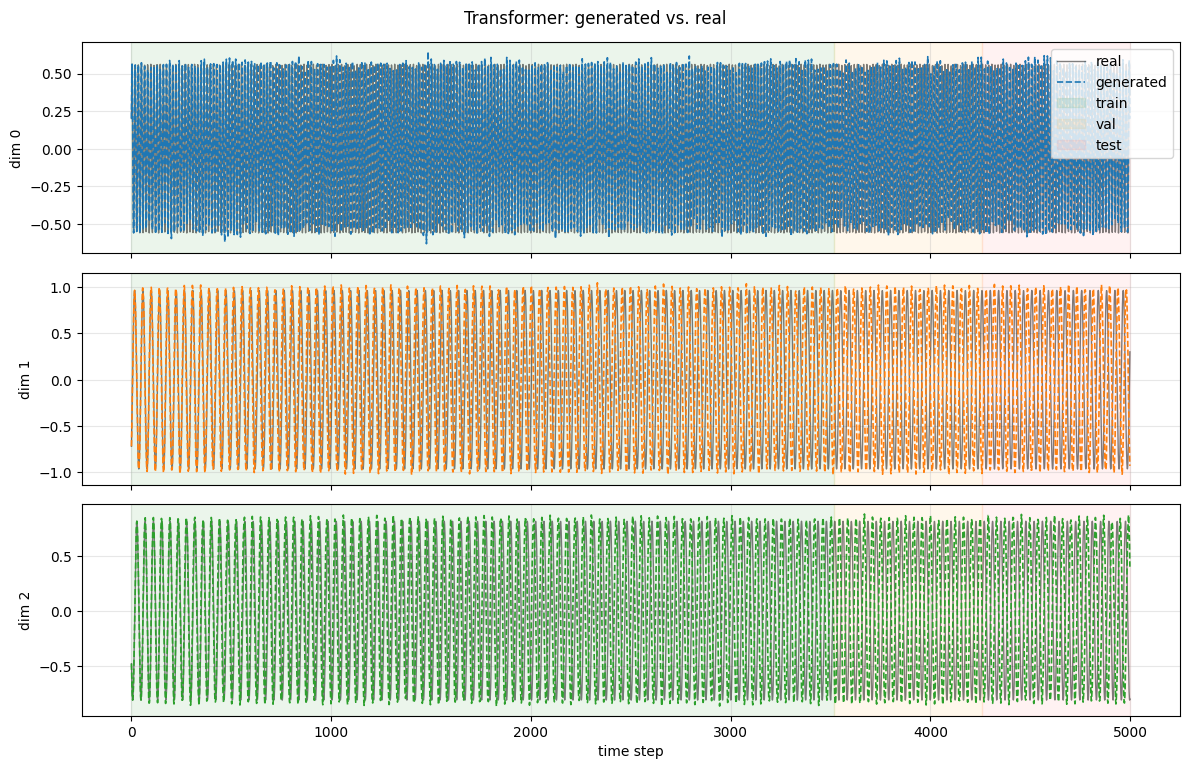

In [10]:
# Prepare a warm seed for the first W-1 real raw steps
seed_first = torch.from_numpy(DATA['series'][:WINDOW_SIZE-1]).float().to(device)

# Generate sequences for each model (with chained windows inside generate_full_sequence)
generated = {}
with torch.no_grad():
    for name, m in [("RNN", rnn_model), ("LSTM", lstm_model), ("GRU", gru_model), ("Transformer", tr_model)]:
        gen_full = m.generate_full_sequence(
            stride=STRIDE,
            total_len=T,
            window_size=WINDOW_SIZE,
            seed_first=seed_first,
            device=device
        )
        generated[name] = gen_full.cpu().numpy()

# (Optional) quick sanity: print average variance across dims to catch flatlines
for name, gen in generated.items():
    print(f"{name} mean var across dims: {np.var(gen, axis=0).mean():.6f}")

# Compute boundaries in time steps for train/val/test in the full sequence for shading
N_win = DATA['windows'].shape[0]
idx_train = int(0.7 * N_win)
idx_val = int(0.85 * N_win)
# Convert window-index boundaries to time-step boundaries approximately
# Training windows cover from 0 to start_indices[idx_train] + WINDOW_SIZE
train_end_t = int(DATA['start_indices'][idx_train] + WINDOW_SIZE)
val_end_t = int(DATA['start_indices'][idx_val] + WINDOW_SIZE)
train_end_t = min(train_end_t, T)
val_end_t = min(val_end_t, T)

# For each model, show per-dimension plots with train/val/test shading
for name, gen in generated.items():
    real = DATA['series']
    fig, axes = plt.subplots(D, 1, figsize=(12, 2.6*D), sharex=True)
    fig.suptitle(f"{name}: generated vs. real")

    if D == 1:
        axes = [axes]

    for d in range(D):
        ax = axes[d]
        ax.plot(real[:, d], color='k', alpha=0.5, linewidth=1.0, label='real')
        ax.plot(gen[:, d], color=f"C{d}", linestyle='--', linewidth=1.2, label='generated')
        # Shade regions
        ax.axvspan(0, train_end_t, color='green', alpha=0.08, label='train' if d == 0 else None)
        ax.axvspan(train_end_t, val_end_t, color='orange', alpha=0.08, label='val' if d == 0 else None)
        ax.axvspan(val_end_t, T, color='red', alpha=0.05, label='test' if d == 0 else None)
        ax.set_ylabel(f"dim {d}")
        ax.grid(alpha=0.3)

    axes[-1].set_xlabel("time step")
    axes[0].legend(loc='upper right')
    plt.tight_layout()
    plt.show()
